# Overview of Content:

### mlo_05_fft:

__Sections__:
- Main Module Import Section and Notebook Settings
- Initialize Custom Functions
- Read Notebook Variables
- FFT Calculations
- Mauna Loa FFT with Window Function only (no Zero-Padding)
- Mauna Loa FFT with Zero-Padding only
- Mauna Loa FFT with Zero-Padding and Window-Function
- Mauna Loa FFT with Zero-Padding + Window-Function (same Time-Range as ONI-Data)
- Oceanic Nino Index (ONI) FFT without Zeropadding / Window Function
- ONI FFT with Zero-Padding and Window-Function
- ONI FFT with Zero-Padding and Window-Function (same Time-Range as Mauna Loa-Data)


__Save Dataframes as Notebook Variables and as Text Files__:
- FFT Calculations:
    - fft_mmlo_nopad_nowin
- Mauna Loa FFT with Window Function only (no Zero-Padding):
    - fft_mmlo_onlywin_hann
    - fft_mmlo_onlywin_hamm
    - fft_mmlo_onlywin_black
    - fft_mmlo_onlywin_nuttall
    - fft_mmlo_onlywin_flattop
- Mauna Loa FFT with Zero-Padding only:
    - fft_mmlo_onlypad
- Mauna Loa FFT with Zero-Padding and Window-Function:
    - fft_mmlo
- Mauna Loa FFT with Zero-Padding + Window-Function (same Time-Range as ONI-Data):
    - fft_mmlo_cut_a 
- Oceanic Nino Index (ONI) FFT without Zeropadding / Window Function:
    - fft_oeni_nopad_nowin
- ONI FFT with Zero-Padding and Window-Function:
    - fft_oeni
- ONI FFT with Zero-Padding and Window-Function (same Time-Range as Mauna Loa-Data):
    - fft_oeni_cut_a

    
__Plot and Save Figures__:
- FFT Calculations:
    - fft_mmlo_nopad_nowin_bins.pdf
    - fft_mmlo_nopad_nowin_freq.pdf
    - fft_mmlo_nopad_nowin_years.pdf
- Mauna Loa FFT with Window Function only (no Zero-Padding):
    - fft_mmlo_onlywin.pdf
    - fft_mmlo_onlywin_detail.pdf
- Mauna Loa FFT with Zero-Padding only:
    - fft_mmlo_onlypad.pdf
    - fft_mmlo_win_pad_compare_a_detail.pdf
- Mauna Loa FFT with Zero-Padding and Window-Function:
    - fft_mmlo_win_pad_compare.pdf
    - fft_mmlo_compare.pdf
    - fft_mmlo_win_pad_compare_b.pdf
    - fft_mmlo_padwin.pdf
    - fft_mmlo_win_pad_compare_a.pdf
- ONI FFT with Zero-Padding and Window-Function:
    - fft_oeni_compare.pdf

## Main Module Import Section and Notebook Settings

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.fftpack import fft
from scipy import signal
from scipy.signal import butter, lfilter
import math
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['lines.linewidth'] = 0.7
rcParams['figure.figsize'] = 9, 5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib

%config InlineBackend.figure_format = 'retina'

myred = '#E24A33'
myblue = '#348ABD'

## Initialize Custom Functions

In [2]:
def bin_yr(bin_peak, bins_tot):
    """
    calculates the corresponding year of a bin
    """
    if bin_peak <=0:
        bin_peak = 0.5
        
    return (bin_peak * get_res(bins_tot) * yr_sec())**-1

In [3]:
def cnv_frq_yr(frq):
    """
    
    """
    if (type(frq) is float) or (type(frq) is int) or (type(frq) is np.float64):
        result = (frq ** -1) / cnv_yr_sec(1)
    else:
        frq_yr = (frq[1:] ** -1) / cnv_yr_sec(1)
        result = np.append(frq_yr, 0)
    return result

In [4]:
def cnv_yr_frq(a):
    """
    """
    return cnv_yr_sec(a) ** -1

In [5]:
def cnv_yr_sec(t):
    """
    """
    return t * 60 * 60 * 24 * 365  # seconds per year

In [6]:
def fft_frq_axis(idx, n, bins_tot, fs=None):
    """
    calculates bin number for one side, frequencies and sampling rate
    """
    
    if fs is None:
        ts = (idx[-1] - idx[0]).total_seconds()  # delta time of whole sample in sec
        fs = n / ts  # frequency sample in hertz

    n_oneside = math.ceil(bins_tot / 2)  # number for one side of spectrum

    freq = np.arange(0, fs + (fs / bins_tot), fs / bins_tot)  # make sure last frequency delta gets included (fs+(fs/n))
    freq = freq[range(n_oneside)]

    return n_oneside, freq, fs


In [7]:
def frq_res(bins, m=1):
    """
    calculates frequency resolution
    """
    fs = fs_monthly(m)
    return 0.5 * fs / bins

In [8]:
def fs_monthly(n):
    """
    calculates
    """
    yr_sec = 60 * 60 * 24 * 365
    m_per_yr = 12 / n
    m_sec = yr_sec / m_per_yr
    fs_m = 1 / m_sec
    return fs_m

In [9]:
def get_frq_range(frq, start, end):
    """
    """
    return frq[(frq >= start) & (frq <= end)]

In [10]:
def get_fs(t):
    """
    returns sampling rate in Hz from time period in s
    """
    return 1 / t

In [11]:
def yr_sec(a=1):
    """
    convert years into seconds
    """
    return a * 60 * 60 * 24 * 365

In [12]:
def m_sec(m=1):
    """
    convert months into seconds
    """
    m_per_yr = 12 / m
    return yr_sec() / m_per_yr

In [13]:
def get_res(bins, fs=get_fs(m_sec())):
    """
    calculate the resolution / time per bin in s
    """
    return 0.5 * fs / bins

In [14]:
def mfft(time_index, sig, w='hanning', pad_fac=1):
    """
    custom made fft transform to frequency domain
    window functions [w]: black, hanning, hamming, nuttall, flattop
    cell padding [c]: as a factor of length of time series
    returns dataframe with freq, bins, time, magnitude, amplitude, phases...
    dataframe is index by bins
    """
    bins = sig.size
    bins_tot = bins * pad_fac
    fs_real = frq_res (bins_tot)
    
    n_oneside, freq, fs = fft_frq_axis(time_index, bins, bins_tot)

    # window functions
    if w == 'black':
        w = signal.blackman(time_index.size)
        
    elif w == 'hanning':
        w = signal.hanning(time_index.size)
    
    elif w == 'hamming':
        w = signal.hamming(time_index.size)
        
    elif w == 'flattop':
        w = signal.flattop(time_index.size)
    
    elif w == 'nuttall':
        w = signal.nuttall(time_index.size)
        
    else:
        w = 1  # no window function will be applied if there have not been any matches
        
    fft_sig = fft(sig * w, n=bins_tot)  # fft calculation with optional window function
    fft_sig = fft_sig[range(n_oneside)]  # only one side of fft

    mag = np.abs(fft_sig)  # magnitude
    pha = np.angle(fft_sig)  # phase / angle  
    amp = mag / freq.size  # amplitude
    
    bins_axis = np.arange(0, freq.size, 1)
    
    # create array of years for axis
    period_years = []
    for i in bins_axis:
        period_years.append(bin_yr(i, bins_axis.size))
    period_years = np.asarray(period_years)
    
    df = pd.DataFrame()
    df['freq'] = freq
    df['bin'] = bins_axis
    df['bins_total'] = freq.size
    df['period_yr'] = period_years
    df['mag'] = mag
    df['mag_norm'] = mag / np.max(np.abs(mag))
    df['amp'] = amp
    df['amp_norm'] = amp / np.max(np.abs(amp))
    df['pha'] = pha
    df['pha_norm'] = pha / np.max(np.abs(pha))

    return df.set_index(['bin'], drop=False)

## Read Notebook Variables

In [15]:
# read internal jupyter notebook variables

# stored via notebook: mlo_01_import.ipynb:
%store -r mmlo
%store -r oeni

# stored via notebook: mlo_02_merge_data.ipynb:
%store -r cut_a

## FFT Calculations

### Standard Options for FFT Transform

In [16]:
padding_fac = 300  # padding factor / 1: no zero-padding
w_func = 'hamming'  # type of window function: ['hanning', 'hamming', 'black', 'nuttall', 'flattop'] / 1: no window-function

### Mauna Loa FFT without Zeropadding / Window Function

In [17]:
fft_mmlo_nopad_nowin = mfft(mmlo.index, mmlo.mmlo_notrend, w=1, pad_fac=1)
fft_mmlo_nopad_nowin.tail()
%store fft_mmlo_nopad_nowin
%store fft_mmlo_nopad_nowin >data_results/fft_mmlo_nopad_nowin.txt

,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
351,1.877224e-07,351,356,0.169041,9.247600,0.011427,0.025976,0.011427,-3.031501,-0.964957
352,1.882572e-07,352,356,0.168561,7.199347,0.008896,0.020223,0.008896,2.794854,0.889630
353,1.887920e-07,353,356,0.168083,3.672395,0.004538,0.010316,0.004538,-2.485236,-0.791075
354,1.893268e-07,354,356,0.167608,1.573808,0.001945,0.004421,0.001945,-1.324437,-0.421581
355,1.898617e-07,355,356,0.167136,3.941808,0.004871,0.011072,0.004871,1.045417,0.332767


Stored 'fft_mmlo_nopad_nowin' (DataFrame)
Writing 'fft_mmlo_nopad_nowin' (DataFrame) to file 'data_results/fft_mmlo_nopad_nowin.txt'.


*fft_mmlo_nopad_nowin table results with:*
- freq: frequency in hertz
- bin: frequency bin number
- bins_total: total number of bins
- period _ yr: frequency period in years
- mag: magnitude
- amp: amplitude
- pha: phase shift
- _ norm: normalized data

###### X-Axis: Bins

<IPython.core.display.Javascript object>


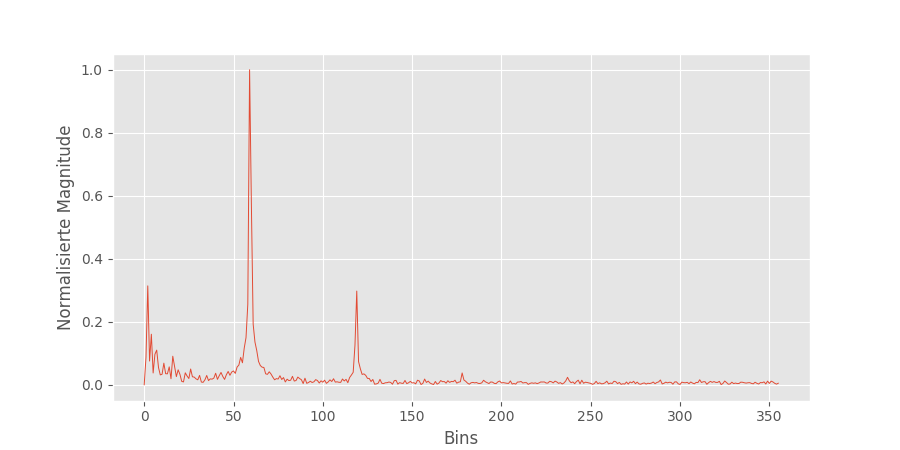

In [18]:
rcParams['figure.figsize'] = 9, 4.5
x_start = 0
x_stop = 40000
fig = plt.figure()
plt.plot(fft_mmlo_nopad_nowin.mag_norm.values, label='MLO: ohne Zero-Padding / Fensterfunktion')
plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Bins')
# plt.xlim(x_start, x_stop)
# plt.xscale('log')
# plt.legend()
plt.savefig('plots/fft_mmlo_nopad_nowin_bins.pdf')

###### X-Axis: Frequency [Hz]

<IPython.core.display.Javascript object>


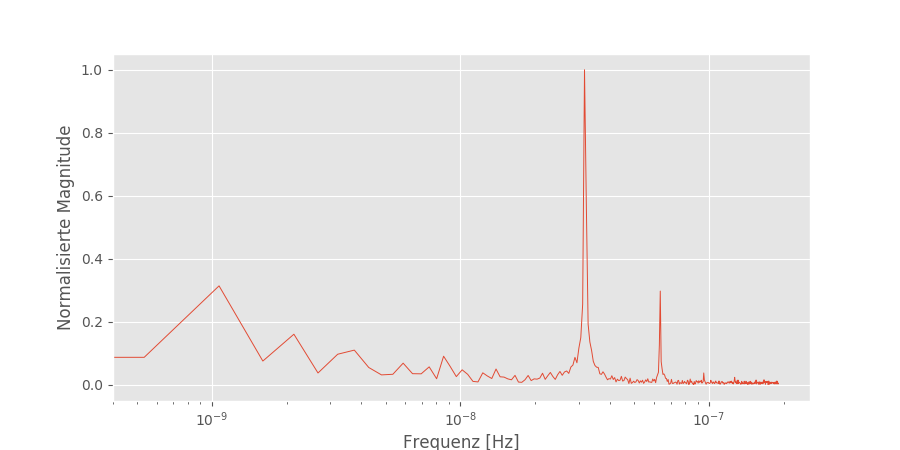

In [19]:
rcParams['figure.figsize'] = 9, 4.5

fig = plt.figure()
plt.plot(fft_mmlo_nopad_nowin.freq.values, fft_mmlo_nopad_nowin.mag_norm.values, label='MLO: ohne Zero-Padding / Fensterfunktion')
plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Frequenz [Hz]')

plt.xscale('log')
# plt.legend()
plt.savefig('plots/fft_mmlo_nopad_nowin_freq.pdf')

###### X-Axis: Frequency Time Period [Years]

<IPython.core.display.Javascript object>


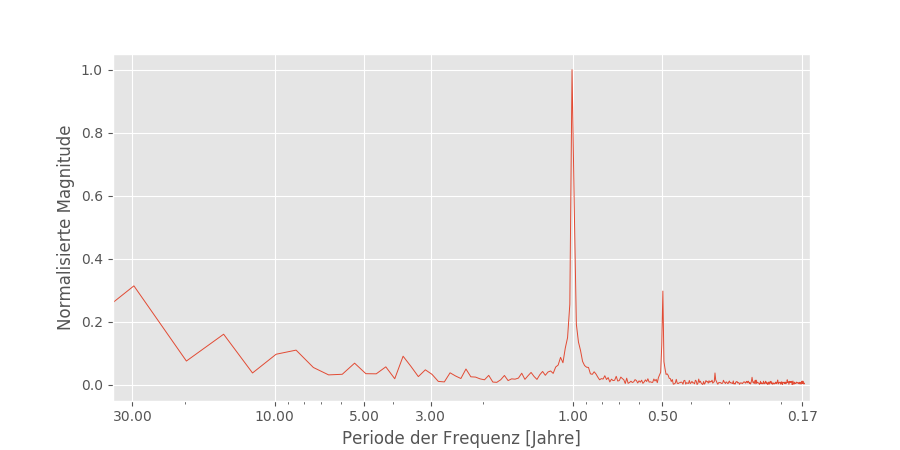

(35, 0.16)

In [20]:
rcParams['figure.figsize'] = 9, 4.5
x_years = [0.17, 0.5, 1, 3, 5, 10, 30]
x_start = 35
x_stop = 0.16
fig,ax = plt.subplots()
ax.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, label='MLO: ohne Zero-Padding / Fensterfunktion')
ax.set_ylabel('Normalisierte Magnitude')
ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
ax.set_xscale('log')
ax.set_xticks(x_years)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig('plots/fft_mmlo_nopad_nowin_years.pdf')

### Mauna Loa FFT with Window Function only (no Zero-Padding)

##### fft_mmlo_onlywin_hann

In [21]:
fft_mmlo_onlywin_hann = mfft(mmlo.index, mmlo.mmlo_notrend, w='hanning', pad_fac=1)
# fft_mmlo_onlywin_hann.tail()
%store fft_mmlo_onlywin_hann
%store fft_mmlo_onlywin_hann >data_results/fft_mmlo_onlywin_hann.txt

Stored 'fft_mmlo_onlywin_hann' (DataFrame)
Writing 'fft_mmlo_onlywin_hann' (DataFrame) to file 'data_results/fft_mmlo_onlywin_hann.txt'.


##### fft_mmlo_onlywin_hamm

In [22]:
fft_mmlo_onlywin_hamm = mfft(mmlo.index, mmlo.mmlo_notrend, w='hamming', pad_fac=1)
# fft_mmlo_onlywin_hamm.tail()
%store fft_mmlo_onlywin_hamm
%store fft_mmlo_onlywin_hamm >data_results/fft_mmlo_onlywin_hamm.txt

Stored 'fft_mmlo_onlywin_hamm' (DataFrame)
Writing 'fft_mmlo_onlywin_hamm' (DataFrame) to file 'data_results/fft_mmlo_onlywin_hamm.txt'.


##### fft_mmlo_onlywin_black

In [23]:
fft_mmlo_onlywin_black = mfft(mmlo.index, mmlo.mmlo_notrend, w='black', pad_fac=1)
# fft_mmlo_onlywin_black.tail()
%store fft_mmlo_onlywin_black
%store fft_mmlo_onlywin_black >data_results/fft_mmlo_onlywin_black.txt

Stored 'fft_mmlo_onlywin_black' (DataFrame)
Writing 'fft_mmlo_onlywin_black' (DataFrame) to file 'data_results/fft_mmlo_onlywin_black.txt'.


##### fft_mmlo_onlywin_nuttall

In [24]:
fft_mmlo_onlywin_nuttall = mfft(mmlo.index, mmlo.mmlo_notrend, w='nuttall', pad_fac=1)
%store fft_mmlo_onlywin_nuttall
%store fft_mmlo_onlywin_nuttall >data_results/fft_mmlo_onlywin_nuttall.txt

Stored 'fft_mmlo_onlywin_nuttall' (DataFrame)
Writing 'fft_mmlo_onlywin_nuttall' (DataFrame) to file 'data_results/fft_mmlo_onlywin_nuttall.txt'.


##### fft_mmlo_onlywin_flattop

In [25]:
fft_mmlo_onlywin_flattop = mfft(mmlo.index, mmlo.mmlo_notrend, w='flattop', pad_fac=1)
# fft_mmlo_onlywin_flattop.tail()
%store fft_mmlo_onlywin_flattop
%store fft_mmlo_onlywin_flattop >data_results/fft_mmlo_onlywin_flattop.txt

Stored 'fft_mmlo_onlywin_flattop' (DataFrame)
Writing 'fft_mmlo_onlywin_flattop' (DataFrame) to file 'data_results/fft_mmlo_onlywin_flattop.txt'.


##### Mauna Loa FFT Results with Window Functions (1-10 Years)

<IPython.core.display.Javascript object>


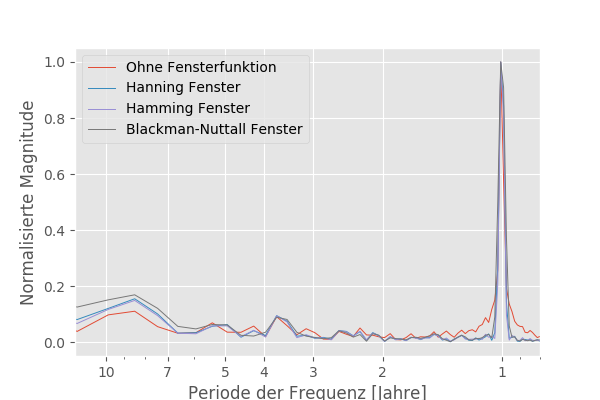

(12, 0.8)

In [26]:
rcParams['figure.figsize'] = 6, 4

x_start = 12
x_stop = 0.8
x_years = [1, 2, 3, 4, 5, 7, 10]

fig,ax = plt.subplots()
ax.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, label='Ohne Fensterfunktion')
ax.plot(fft_mmlo_onlywin_hann.period_yr.values, fft_mmlo_onlywin_hann.mag_norm.values, label='Hanning Fenster')
ax.plot(fft_mmlo_onlywin_hamm.period_yr.values, fft_mmlo_onlywin_hamm.mag_norm.values, label='Hamming Fenster')
# ax.plot(fft_mmlo_onlywin_black.period_yr.values, fft_mmlo_onlywin_black.mag_norm.values, label='Blackman Fenster')
ax.plot(fft_mmlo_onlywin_black.period_yr.values, fft_mmlo_onlywin_nuttall.mag_norm.values, label='Blackman-Nuttall Fenster')
# ax.plot(fft_mmlo_onlywin_black.period_yr.values, fft_mmlo_onlywin_flattop.mag_norm.values, label='Flat-Top Fenster')

ax.set_ylabel('Normalisierte Magnitude')
ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
ax.set_xscale('log')
ax.set_xticks(x_years)
# ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend()
plt.savefig('plots/fft_mmlo_onlywin.pdf')

##### Mauna Loa FFT Results with Window Functions (1-Year-Peak):

<IPython.core.display.Javascript object>


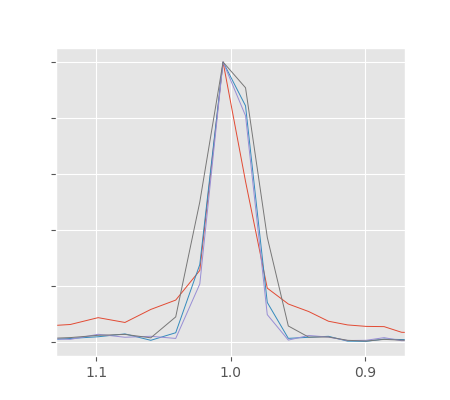

(1.13, 0.87)

In [27]:
rcParams['figure.figsize'] = 4.5, 4

x_start = 1.13
x_stop = 0.87
x_years = [0.9, 1, 1.1]

fig,ax = plt.subplots()
ax.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, label='MLO:\nOhne Fensterfunktion')
ax.plot(fft_mmlo_onlywin_hann.period_yr.values, fft_mmlo_onlywin_hann.mag_norm.values, label='Hanning Fenster')
ax.plot(fft_mmlo_onlywin_hamm.period_yr.values, fft_mmlo_onlywin_hamm.mag_norm.values, label='Hamming Fenster')
# ax.plot(fft_mmlo_onlywin_black.period_yr.values, fft_mmlo_onlywin_black.mag_norm.values, label='Blackman Fenster')
ax.plot(fft_mmlo_onlywin_black.period_yr.values, fft_mmlo_onlywin_nuttall.mag_norm.values, label='Blackman-Nuttall Fenster')
# ax.plot(fft_mmlo_onlywin_black.period_yr.values, fft_mmlo_onlywin_flattop.mag_norm.values, label='Flat-Top Fenster')

# ax.set_ylabel('Normalisierte Magnitude')
# ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
# ax.set_xscale('log')
ax.set_xticks(x_years)
ax.yaxis.set_major_formatter(plt.NullFormatter())
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.legend()
plt.savefig('plots/fft_mmlo_onlywin_detail.pdf')

### Mauna Loa FFT with Zero-Padding only

In [28]:
fft_mmlo_onlypad = mfft(mmlo.index, mmlo.mmlo_notrend, w=1, pad_fac=padding_fac)
# fft_mmlo_onlypad.tail()
%store fft_mmlo_onlypad
%store fft_mmlo_onlypad >data_results/fft_mmlo_onlypad.txt

Stored 'fft_mmlo_onlypad' (DataFrame)
Writing 'fft_mmlo_onlypad' (DataFrame) to file 'data_results/fft_mmlo_onlypad.txt'.


##### Mauna Loa FFT Results with and without Zero-Padding only:

<IPython.core.display.Javascript object>


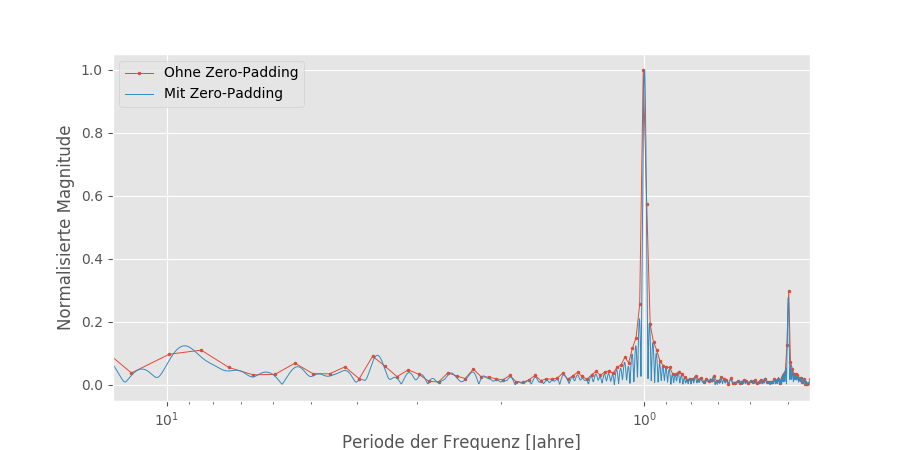

(13, 0.45)

In [29]:
rcParams['figure.figsize'] = 9, 4.5


x_start = 13
x_stop = 0.45
fig = plt.figure()
plt.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, '.-', markersize=3, label='Ohne Zero-Padding')
plt.plot(fft_mmlo_onlypad.period_yr.values, fft_mmlo_onlypad.mag_norm.values, label='Mit Zero-Padding')

plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Periode der Frequenz [Jahre]')
plt.xlim(x_start, x_stop)
plt.xscale('log')
plt.legend()
plt.savefig('plots/fft_mmlo_onlypad.pdf')

##### Mauna Loa FFT Results with and without Zero-Padding only (comparing 1-Year-Peak):

<IPython.core.display.Javascript object>


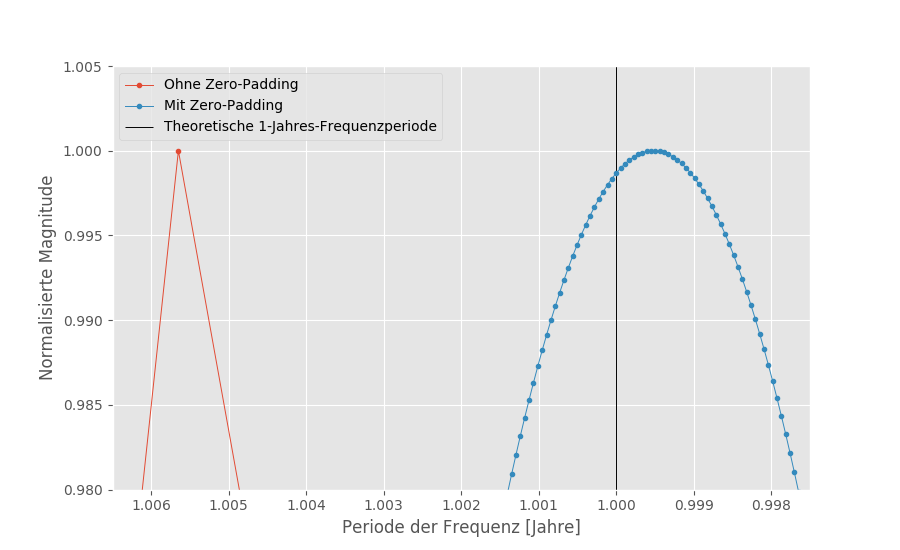

(1.0065, 0.9975)

(0.98, 1.005)

In [30]:
rcParams['figure.figsize'] = 9, 5.5
y_start = 0.98
y_stop = 1.005
x_start = 1.0065
x_stop = 0.9975
# x_years = [0.5, 1]

fig,ax = plt.subplots()
ax.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, '.-', label='Ohne Zero-Padding')
ax.plot(fft_mmlo_onlypad.period_yr.values, fft_mmlo_onlypad.mag_norm.values, '.-', label='Mit Zero-Padding')
# ax.plot(fft_mmlo.period_yr.values, fft_mmlo.mag_norm.values, label='Zero-Padding und ' + w_func + '-Fenster')
ax.vlines(1, y_start, y_stop, linestyles='solid', colors='k', label='Theoretische 1-Jahres-Frequenzperiode')

ax.set_ylabel('Normalisierte Magnitude')
ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
ax.set_ylim(y_start, y_stop)
# ax.set_xscale('log')
# ax.set_xticks(x_years)
# ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(loc='upper left')
plt.savefig('plots/fft_mmlo_win_pad_compare_a_detail.pdf')

### Mauna Loa FFT with Zero-Padding and Window-Function

In [31]:
fft_mmlo = mfft(mmlo.index, mmlo.mmlo_notrend, w=w_func, pad_fac=padding_fac)
# fft_mmlo.tail()
%store fft_mmlo
%store fft_mmlo >data_results/fft_mmlo.txt

Stored 'fft_mmlo' (DataFrame)
Writing 'fft_mmlo' (DataFrame) to file 'data_results/fft_mmlo.txt'.


##### Mauna Loa FFT Results with and without Zero-Padding / Window-Function:

<IPython.core.display.Javascript object>


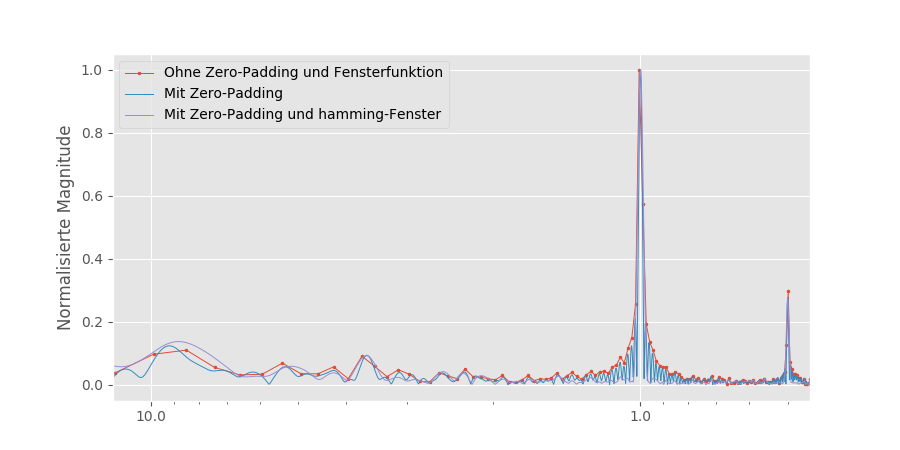

(12, 0.45)

In [32]:
rcParams['figure.figsize'] = 9, 4.5

x_start = 12
x_stop = 0.45
x_years = [0.5, 1, 3, 5, 7, 10]

fig,ax = plt.subplots()
ax.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values,  '.-', markersize=3, label='Ohne Zero-Padding und Fensterfunktion')
ax.plot(fft_mmlo_onlypad.period_yr.values, fft_mmlo_onlypad.mag_norm.values, label='Mit Zero-Padding')
ax.plot(fft_mmlo.period_yr.values, fft_mmlo.mag_norm.values, label='Mit Zero-Padding und ' + w_func + '-Fenster')


ax.set_ylabel('Normalisierte Magnitude')
# ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
# ax.set_ylim(0, 0.15)
ax.set_xscale('log')
# ax.set_xticks(x_years)
# ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend()
plt.savefig('plots/fft_mmlo_win_pad_compare.pdf')

##### Mauna Loa FFT Results with and without Zero-Padding + Window-Function:

<IPython.core.display.Javascript object>


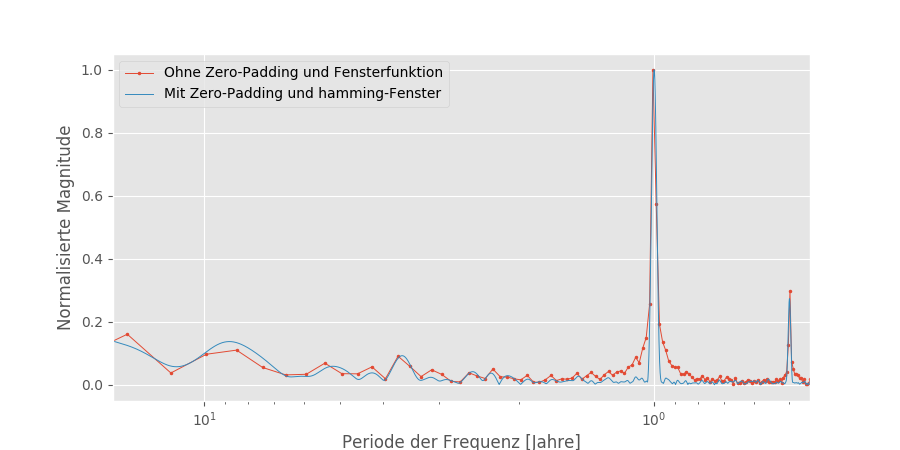

(16, 0.45)

In [33]:
rcParams['figure.figsize'] = 9, 4.5
x_stop = 0.45
x_start = 16
fig = plt.figure()
plt.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, '.-', markersize=3, label='Ohne Zero-Padding und Fensterfunktion')
plt.plot(fft_mmlo.period_yr.values, fft_mmlo.mag_norm.values, label='Mit Zero-Padding und ' + w_func + '-Fenster')

plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Periode der Frequenz [Jahre]')
plt.xlim(x_start, x_stop)
plt.xscale('log')
plt.legend()
plt.savefig('plots/fft_mmlo_compare.pdf')

##### Mauna Loa FFT Results with and without Zero-Padding / Window-Function (3 - 8 Years):

<IPython.core.display.Javascript object>


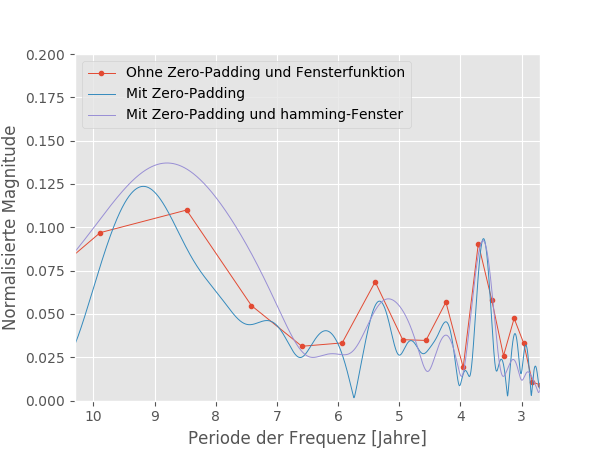

(10.3, 2.7)

(0, 0.2)

In [34]:
rcParams['figure.figsize'] = 6, 4.5

x_start = 10.3
x_stop = 2.7
x_years = [3, 4, 5, 7, 10]

fig,ax = plt.subplots()
ax.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, '.-', label='Ohne Zero-Padding und Fensterfunktion')
ax.plot(fft_mmlo_onlypad.period_yr.values, fft_mmlo_onlypad.mag_norm.values, label='Mit Zero-Padding')
ax.plot(fft_mmlo.period_yr.values, fft_mmlo.mag_norm.values, label='Mit Zero-Padding und ' + w_func + '-Fenster')

ax.set_ylabel('Normalisierte Magnitude')
ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
ax.set_ylim(0, 0.2)
# ax.set_xscale('log')
# ax.set_xticks(x_years)
# ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(loc='upper left')
plt.savefig('plots/fft_mmlo_win_pad_compare_b.pdf')

##### Mauna Loa FFT Results with and without Zero-Padding / Window-Function (comparing 0.5 and 1-Year-Peak):

<IPython.core.display.Javascript object>


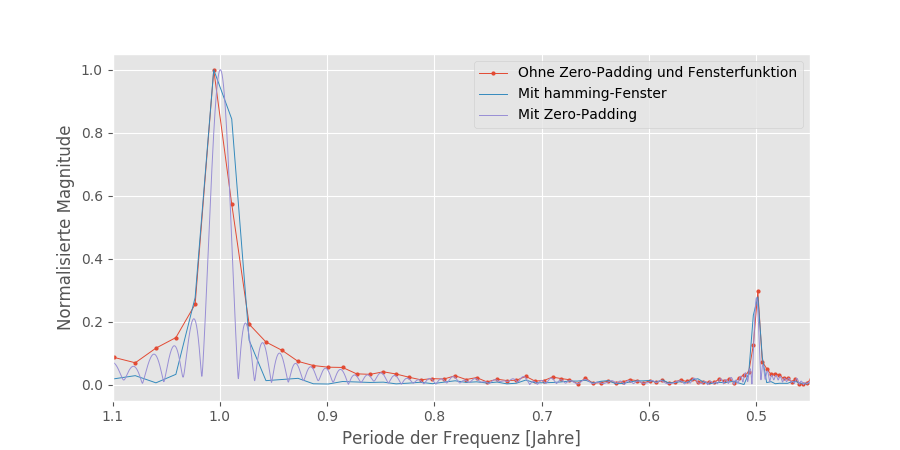

(1.1, 0.45)

In [35]:
rcParams['figure.figsize'] = 9, 4.5


x_start = 1.1
x_stop = 0.45
fig = plt.figure()
plt.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, '.-', markersize=4, label='Ohne Zero-Padding und Fensterfunktion')
plt.plot(fft_mmlo_onlywin_hann.period_yr.values, fft_mmlo_onlywin_hann.mag_norm.values, label='Mit ' + w_func + '-Fenster')
plt.plot(fft_mmlo_onlypad.period_yr.values, fft_mmlo_onlypad.mag_norm.values, label='Mit Zero-Padding')

plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Periode der Frequenz [Jahre]')
plt.xlim(x_start, x_stop)
# plt.xscale('log')
plt.legend()
plt.savefig('plots/fft_mmlo_padwin.pdf')

##### Mauna Loa FFT Results with and without Zero-Padding + Window-Function (comparing 1-Year-Peak):

<IPython.core.display.Javascript object>


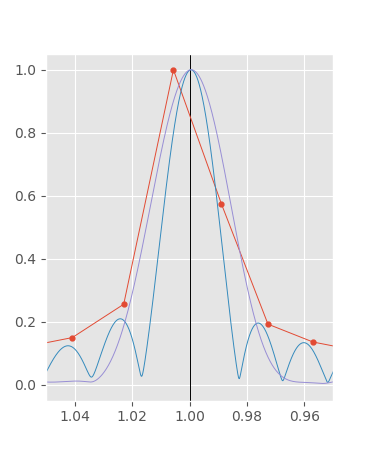

(1.05, 0.95)

(-0.05, 1.05)

In [36]:
rcParams['figure.figsize'] = 3.7, 4.5

x_start = 1.05
x_stop = 0.95
y_start = -0.05
y_stop = 1.05
# x_years = [0.5, 1]

fig,ax = plt.subplots()
ax.plot(fft_mmlo_nopad_nowin.period_yr.values, fft_mmlo_nopad_nowin.mag_norm.values, '.-',  markersize=7, label='Ohne Zero-Padding und Fensterfunktion')
ax.plot(fft_mmlo_onlypad.period_yr.values, fft_mmlo_onlypad.mag_norm.values, label='Zero-Padding')
ax.plot(fft_mmlo.period_yr.values, fft_mmlo.mag_norm.values, label='Mit Zero-Padding und ' + w_func + '-Fenster')
ax.vlines(1, y_start, y_stop, linestyles='solid', colors='k', label='1-Jahres-Frequenzperiode')


# ax.set_ylabel('Normalisierte Magnitude')
# ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
ax.set_ylim(y_start, y_stop)
# ax.set_xscale('log')
# ax.set_xticks(x_years)
# ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.legend()
plt.savefig('plots/fft_mmlo_win_pad_compare_a.pdf')

### Mauna Loa FFT with Zero-Padding + Window-Function (same Time-Range as ONI-Data):

In [37]:
fft_mmlo_cut_a = mfft(cut_a.index, cut_a.mmlo_notrend, w=w_func, pad_fac=padding_fac)
# fft_mmlo_cut_a.tail()
%store fft_mmlo_cut_a
%store fft_mmlo_cut_a >data_results/fft_mmlo_cut_a.txt

Stored 'fft_mmlo_cut_a' (DataFrame)
Writing 'fft_mmlo_cut_a' (DataFrame) to file 'data_results/fft_mmlo_cut_a.txt'.


### Oceanic Nino Index (ONI) FFT without Zeropadding / Window Function:

In [38]:
fft_oeni_nopad_nowin = mfft(oeni.index, oeni.oeni_data, w=1, pad_fac=1)
%store fft_oeni_nopad_nowin
%store fft_oeni_nopad_nowin >data_results/fft_oeni_nopad_nowin.txt
fft_oeni_nopad_nowin.tail()

Stored 'fft_oeni_nopad_nowin' (DataFrame)
Writing 'fft_oeni_nopad_nowin' (DataFrame) to file 'data_results/fft_oeni_nopad_nowin.txt'.


,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
400,1.882575e-07,400,405,0.168750,0.892273,0.006458,0.002203,0.006458,-2.362318,-0.755133
401,1.887282e-07,401,405,0.168329,0.660951,0.004784,0.001632,0.004784,-2.014569,-0.643973
402,1.891988e-07,402,405,0.167910,2.321855,0.016805,0.005733,0.016805,-2.907821,-0.929508
403,1.896695e-07,403,405,0.167494,1.111251,0.008043,0.002744,0.008043,3.013185,0.963188
404,1.901401e-07,404,405,0.167079,0.755003,0.005465,0.001864,0.005465,2.920482,0.933555


### ONI FFT with Zero-Padding and Window-Function:

In [39]:
fft_oeni = mfft(oeni.index, oeni.oeni_data, w=w_func, pad_fac=padding_fac)
fft_oeni.tail()
%store fft_oeni
%store fft_oeni >data_results/fft_oeni.txt

,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
121345,1.903676e-07,121345,121350,0.166674,0.073668,0.000718,6.070697e-07,0.000718,0.049668,0.015810
121346,1.903692e-07,121346,121350,0.166672,0.073654,0.000718,6.069523e-07,0.000718,0.039738,0.012649
121347,1.903707e-07,121347,121350,0.166671,0.073643,0.000718,6.068611e-07,0.000718,0.029805,0.009487
121348,1.903723e-07,121348,121350,0.166669,0.073635,0.000718,6.067958e-07,0.000718,0.019871,0.006325
121349,1.903739e-07,121349,121350,0.166668,0.073630,0.000718,6.067567e-07,0.000718,0.009936,0.003163


Stored 'fft_oeni' (DataFrame)
Writing 'fft_oeni' (DataFrame) to file 'data_results/fft_oeni.txt'.


##### ONI FFT Results with and without Zero-Padding / Window-Function:

<IPython.core.display.Javascript object>


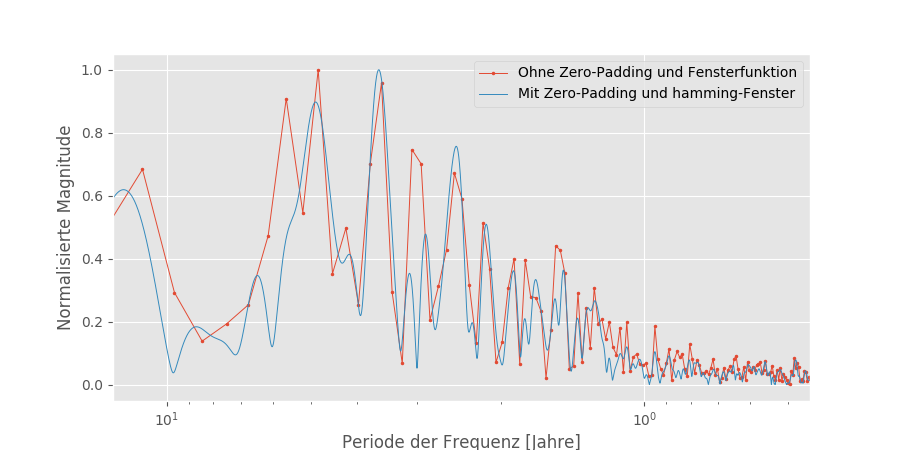

(13, 0.45)

In [40]:
rcParams['figure.figsize'] = 9, 4.5

x_start = 13
x_stop = 0.45
fig = plt.figure()
plt.plot(fft_oeni_nopad_nowin.period_yr.values, fft_oeni_nopad_nowin.mag_norm.values, '.-', markersize=3, label='Ohne Zero-Padding und Fensterfunktion')
plt.plot(fft_oeni.period_yr.values, fft_oeni.mag_norm.values, label='Mit Zero-Padding und ' + w_func + '-Fenster')

plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Periode der Frequenz [Jahre]')
plt.xlim(x_start, x_stop)
plt.xscale('log')
plt.legend()
plt.savefig('plots/fft_oeni_compare.pdf')

### ONI FFT with Zero-Padding and Window-Function (same Time-Range as Mauna Loa-Data):

In [41]:
fft_oeni_cut_a = mfft(cut_a.index, cut_a.oeni_data, w=w_func, pad_fac=padding_fac)
%store fft_oeni_cut_a
%store fft_oeni_cut_a >data_results/fft_oeni_cut_a.txt
fft_oeni_cut_a.tail()

Stored 'fft_oeni_cut_a' (DataFrame)
Writing 'fft_oeni_cut_a' (DataFrame) to file 'data_results/fft_oeni_cut_a.txt'.


,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
106645,1.903841e-07,106645,106650,0.166674,0.135301,0.001461,0.000001,0.001461,0.009897,0.00315
106646,1.903859e-07,106646,106650,0.166673,0.135304,0.001461,0.000001,0.001461,0.007916,0.00252
106647,1.903877e-07,106647,106650,0.166671,0.135307,0.001461,0.000001,0.001461,0.005936,0.00189
106648,1.903894e-07,106648,106650,0.166670,0.135308,0.001461,0.000001,0.001461,0.003957,0.00126
106649,1.903912e-07,106649,106650,0.166668,0.135310,0.001461,0.000001,0.001461,0.001978,0.00063
